
<h1 style='text-align: center; color: blue;'>CS 768 Learning with Graphs Assignment</h1>
<h3 style='text-align: right; color: red;'>~ Shubham Lohiya, 18D100020</h3>

Implementing a node property prediction (classification) model using some popular GNNs such as **GCN**, **GraphSAGE**, **Graph Attention Network**.

**Tools:** PyTorch, Pytorch Geometric  
**Datasets:** Planetoid datasets (cora/citeseer)  

In [1]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import torch.optim as optim
import time

import networkx as nx
import numpy as np

from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader

import matplotlib.pyplot as plt

from itertools import product
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Use GPU if available

In [2]:
# setting seeds for deterministic results
SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
def train_ES(model, loader, opt, args):
    """
      training function with early stopping functionality
    """

    # train
    losses = []
    val_accs = []
    
    es_counter, best_val_acc = 0, -np.inf
    
    for epoch in range(args.max_epochs):
        if es_counter > args.p:
            if args.verbose: print('Early Stopping... Returning best weights!')
            model.load_state_dict(torch.load('best-model.pt'))
            break
            
        total_loss = 0
        model.train()
        for batch in loader:
            batch = batch.to(device)
            opt.zero_grad()
            emb, pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)
        
        val_acc = test(loader, model)
        val_accs.append(val_acc)
        
        if val_acc > best_val_acc:
            torch.save(model.state_dict(), 'best-model.pt')
            best_val_acc = val_acc
            es_counter = 0
        else:
            es_counter += 1
        
        if epoch % 10 == 0 and args.verbose:
            print("Epoch ", epoch, "Loss: ", total_loss, "Val Acc.: ", val_acc)
            
    if epoch == args.max_epochs-1 and args.verbose:
        print('Reached epoch cap without convergence.')

    return val_accs, losses

def test(loader, model, is_validation=True):
    """
        Testing module can be used on validation data / test data 
        Returns fraction of correct predictions
    """
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            data = data.to(device)
            emb, pred = model(data)
            pred = pred.max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = data.y[mask]
            
        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()
    return correct / total
  
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

def run(args):
    """
    Runs the experiment with parameters as stated in args and returns trained model and logs
    """
    dataset = Planetoid('/tmp/'+args.dataset, args.dataset)
    loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

    # build model
    model = GNNFactory(dataset.num_node_features, args.hidden_dim, dataset.num_classes, args)
    model = model.to(device)
    opt = optim.Adam(filter(lambda p : p.requires_grad, model.parameters()),\
                           lr=args.lr, weight_decay=args.weight_decay)


    val_accs, losses = train_ES(model, loader, opt, args)
    
    if args.verbose:
        plt.title(dataset.name)
        plt.plot(losses, label="training loss" + " - " + args.model_type)
        plt.plot(val_accs, label="val accuracy" + " - " + args.model_type)
        plt.legend()
        plt.show()
        
    return model, val_accs, losses

### GNNFactory


In [4]:
class GNNFactory(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args):
        super().__init__()
        """
           Defines all the layers as stated by the provided arguments.           
        """
        build_conv = self.set_conv_model(args.model_type)
        self.dropout = args.dropout
        
        self.convs = nn.ModuleList()
        self.convs.append(build_conv(input_dim, hidden_dim))
        for i in range(args.num_layers-1):
            self.convs.append(build_conv(hidden_dim, hidden_dim))
        self.post_mp = nn.Linear(hidden_dim, output_dim)


    def set_conv_model(self, model_type):
        """
             Based on input mode_type return the convolution layer function.
             model_type: {'GCN','SAGE','GAT'}
        """
        conv_options = {
            'GCN': pyg_nn.GCNConv,
            'SAGE': pyg_nn.SAGEConv,
            'GAT': pyg_nn.GATConv
        }
        return conv_options[model_type]

    def forward(self, data):
        """
        Forward pass of the model. Returns embeddings and log-softmax scores
        """
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        for conv in self.convs:
            x = conv(x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            
        x = self.post_mp(x)
        return emb, F.log_softmax(x, dim=1)
    
    def loss(self, pred, label):
        return F.nll_loss(pred, label)

Epoch  0 Loss:  1.7968710660934448 Val Acc.:  0.198
Epoch  10 Loss:  0.9401045441627502 Val Acc.:  0.642
Epoch  20 Loss:  0.3517060875892639 Val Acc.:  0.668
Epoch  30 Loss:  0.19664791226387024 Val Acc.:  0.668
Epoch  40 Loss:  0.17129714787006378 Val Acc.:  0.688
Epoch  50 Loss:  0.1141103133559227 Val Acc.:  0.678
Epoch  60 Loss:  0.19050224125385284 Val Acc.:  0.682
Epoch  70 Loss:  0.1335303783416748 Val Acc.:  0.692
Epoch  80 Loss:  0.09768710285425186 Val Acc.:  0.664
Epoch  90 Loss:  0.10824162513017654 Val Acc.:  0.672
Early Stopping... Returning best weights!


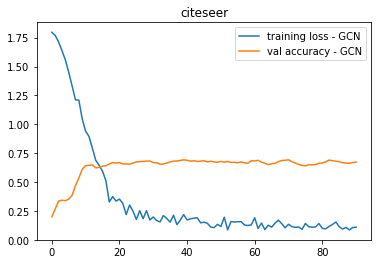

In [5]:
# test GNNFactory and training code

args = {
    'model_type': 'GCN', # "GCN"/"SAGE"/"GAT"
    'dataset': 'citeseer', # "cora/"citeseer"
    'num_layers': 2,
    'batch_size': 32,
    'hidden_dim': 32,
    'dropout': 0.5,
    'max_epochs': 500,
    'p': 50,
    'opt': 'adam',
    'weight_decay': 5e-3,
    'lr': 0.01,
    'verbose': True
}
args = objectview(args)

model, val_accs, losses = run(args)

### Hyperparameter Tuning for GCN

#### (i) Cora dataset

In [6]:
args = {
    'model_type': 'GCN', # "GCN"/"SAGE"/"GAT"
    'dataset': 'cora', # "cora/"citeseer"
    'num_layers': 2,
    'batch_size': 32,
    'hidden_dim': 32,
    'dropout': 0.5,
    'max_epochs': 1000,
    'p': 50,
    'opt': 'adam',
    'weight_decay': 5e-3,
    'lr': 0.01,
    'verbose': False
}

num_layers_choices = list(range(1,4))
hidden_dim_choices = list([32,64,128,256])
lr_choices = [0.001, 0.01]
dropout_choices = [0.25, 0.5]

update_keys = ['num_layers', 'hidden_dim', 'lr', 'dropout']
candidates = list(product(num_layers_choices, hidden_dim_choices, lr_choices, dropout_choices))

In [7]:
best_args, best_val_acc = args, -np.inf
for candidate in tqdm(candidates):
    args.update(dict(zip(update_keys, candidate)))
    model, val_accs, losses = run(objectview(args))
    max_val_acc = np.max(val_accs)
    if max_val_acc > best_val_acc:
        best_val_acc = max_val_acc
        best_args = args.copy()

100%|███████████████████████████████████████████| 48/48 [01:40<00:00,  2.10s/it]


Best tuned args:
{'model_type': 'GCN', 'dataset': 'cora', 'num_layers': 2, 'batch_size': 32, 'hidden_dim': 64, 'dropout': 0.25, 'max_epochs': 1000, 'p': 50, 'opt': 'adam', 'weight_decay': 0.005, 'lr': 0.01, 'verbose': False}
Epoch  0 Loss:  1.950199007987976 Val Acc.:  0.37
Epoch  10 Loss:  0.3071921765804291 Val Acc.:  0.8
Epoch  20 Loss:  0.02982516586780548 Val Acc.:  0.782
Epoch  30 Loss:  0.06851968914270401 Val Acc.:  0.782
Epoch  40 Loss:  0.05813375115394592 Val Acc.:  0.748
Epoch  50 Loss:  0.04986928030848503 Val Acc.:  0.776
Epoch  60 Loss:  0.06688863039016724 Val Acc.:  0.772
Early Stopping... Returning best weights!


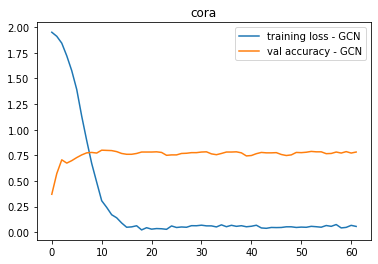

Accuracy of tuned model on Test set: 80.90%


In [8]:
# Test-set performance
print('Best tuned args:')
print(best_args)
best_args['verbose'] = True
best_args = objectview(best_args)

dataset = Planetoid('/tmp/'+best_args.dataset, best_args.dataset)
loader = DataLoader(dataset, batch_size=best_args.batch_size, shuffle=True)

model, val_accs, losses = run(best_args)

acc = test(loader, model, is_validation=False)
print(f'Accuracy of tuned model on Test set: {100*acc:.2f}%')

#### (iI) Citeseer dataset

In [9]:
args = {
    'model_type': 'GCN', # "GCN"/"SAGE"/"GAT"
    'dataset': 'citeseer', # "cora"/"citeseer"
    'num_layers': 2,
    'batch_size': 32,
    'hidden_dim': 32,
    'dropout': 0.5,
    'max_epochs': 1000,
    'p': 50,
    'opt': 'adam',
    'weight_decay': 5e-3,
    'lr': 0.01,
    'verbose': False
}

num_layers_choices = list(range(1,4))
hidden_dim_choices = list([32,64,128,256])
lr_choices = [0.001, 0.01]
dropout_choices = [0.25, 0.5]

update_keys = ['num_layers', 'hidden_dim', 'lr', 'dropout']
candidates = list(product(num_layers_choices, hidden_dim_choices, lr_choices, dropout_choices))

In [10]:
best_args, best_val_acc = args, -np.inf
for candidate in tqdm(candidates):
    args.update(dict(zip(update_keys, candidate)))
    model, val_accs, losses = run(objectview(args))
    max_val_acc = np.max(val_accs)
    if max_val_acc > best_val_acc:
        best_val_acc = max_val_acc
        best_args = args.copy()

100%|███████████████████████████████████████████| 48/48 [03:39<00:00,  4.57s/it]


Best tuned args:
{'model_type': 'GCN', 'dataset': 'citeseer', 'num_layers': 3, 'batch_size': 32, 'hidden_dim': 128, 'dropout': 0.5, 'max_epochs': 1000, 'p': 50, 'opt': 'adam', 'weight_decay': 0.005, 'lr': 0.001, 'verbose': False}
Epoch  0 Loss:  1.797153115272522 Val Acc.:  0.144
Epoch  10 Loss:  1.754812240600586 Val Acc.:  0.276
Epoch  20 Loss:  1.657030463218689 Val Acc.:  0.366
Epoch  30 Loss:  1.244509220123291 Val Acc.:  0.594
Epoch  40 Loss:  0.6382124423980713 Val Acc.:  0.68
Epoch  50 Loss:  0.27810198068618774 Val Acc.:  0.678
Epoch  60 Loss:  0.14508682489395142 Val Acc.:  0.67
Epoch  70 Loss:  0.10713060945272446 Val Acc.:  0.682
Epoch  80 Loss:  0.07712908089160919 Val Acc.:  0.668
Epoch  90 Loss:  0.09563130885362625 Val Acc.:  0.684
Early Stopping... Returning best weights!


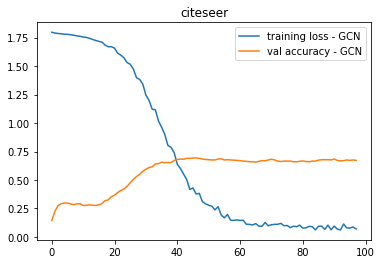

Accuracy of tuned model on Test set: 69.30%


In [11]:
# Test-set performance
print('Best tuned args:')
print(best_args)
best_args['verbose'] = True
best_args = objectview(best_args)

dataset = Planetoid('/tmp/'+best_args.dataset, best_args.dataset)
loader = DataLoader(dataset, batch_size=best_args.batch_size, shuffle=True)

model, val_accs, losses = run(best_args)

acc = test(loader, model, is_validation=False)
print(f'Accuracy of tuned model on Test set: {100*acc:.2f}%')

### Hyperparameter Tuning for SAGE

#### (i) Cora dataset

In [12]:
args = {
    'model_type': 'SAGE', # "GCN"/"SAGE"/"GAT"
    'dataset': 'cora', # "cora/"citeseer"
    'num_layers': 2,
    'batch_size': 32,
    'hidden_dim': 32,
    'dropout': 0.5,
    'max_epochs': 1000,
    'p': 50,
    'opt': 'adam',
    'weight_decay': 5e-3,
    'lr': 0.01,
    'verbose': False
}

num_layers_choices = list(range(1,4))
hidden_dim_choices = list([32,64,128,256])
lr_choices = [0.001, 0.01]
dropout_choices = [0.25, 0.5]

update_keys = ['num_layers', 'hidden_dim', 'lr', 'dropout']
candidates = list(product(num_layers_choices, hidden_dim_choices, lr_choices, dropout_choices))

In [13]:
best_args, best_val_acc = args, -np.inf
for candidate in tqdm(candidates):
    args.update(dict(zip(update_keys, candidate)))
    model, val_accs, losses = run(objectview(args))
    max_val_acc = np.max(val_accs)
    if max_val_acc > best_val_acc:
        best_val_acc = max_val_acc
        best_args = args.copy()

100%|███████████████████████████████████████████| 48/48 [01:32<00:00,  1.93s/it]


Best tuned args:
{'model_type': 'SAGE', 'dataset': 'cora', 'num_layers': 3, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'max_epochs': 1000, 'p': 50, 'opt': 'adam', 'weight_decay': 0.005, 'lr': 0.01, 'verbose': False}

Epoch  0 Loss:  1.9470014572143555 Val Acc.:  0.058
Epoch  10 Loss:  1.2675859928131104 Val Acc.:  0.56
Epoch  20 Loss:  0.632401168346405 Val Acc.:  0.704
Epoch  30 Loss:  0.27113136649131775 Val Acc.:  0.738
Epoch  40 Loss:  0.24215610325336456 Val Acc.:  0.788
Epoch  50 Loss:  0.17465493083000183 Val Acc.:  0.776
Epoch  60 Loss:  0.1249053031206131 Val Acc.:  0.788
Epoch  70 Loss:  0.0883830189704895 Val Acc.:  0.77
Epoch  80 Loss:  0.11442054808139801 Val Acc.:  0.756
Epoch  90 Loss:  0.08503713458776474 Val Acc.:  0.762
Epoch  100 Loss:  0.15939339995384216 Val Acc.:  0.74
Epoch  110 Loss:  0.1078580990433693 Val Acc.:  0.776
Early Stopping... Returning best weights!


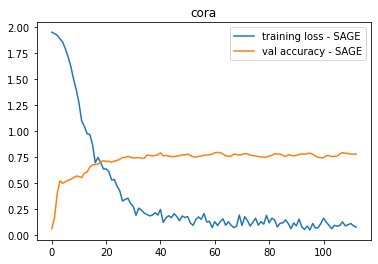

Accuracy of tuned model on Test set: 79.10%


In [14]:
# Test-set performance
print('Best tuned args:')
print(best_args, end='\n\n')
best_args['verbose'] = True
best_args = objectview(best_args)

dataset = Planetoid('/tmp/'+best_args.dataset, best_args.dataset)
loader = DataLoader(dataset, batch_size=best_args.batch_size, shuffle=True)

model, val_accs, losses = run(best_args)

acc = test(loader, model, is_validation=False)
print(f'Accuracy of tuned model on Test set: {100*acc:.2f}%')

#### (iI) Citeseer dataset

In [15]:
args = {
    'model_type': 'SAGE', # "GCN"/"SAGE"/"GAT"
    'dataset': 'citeseer', # "cora"/"citeseer"
    'num_layers': 2,
    'batch_size': 32,
    'hidden_dim': 32,
    'dropout': 0.5,
    'max_epochs': 1000,
    'p': 50,
    'opt': 'adam',
    'weight_decay': 5e-3,
    'lr': 0.01,
    'verbose': False
}

num_layers_choices = list(range(1,4))
hidden_dim_choices = list([32,64,128,256])
lr_choices = [0.001, 0.01]
dropout_choices = [0.25, 0.5]

update_keys = ['num_layers', 'hidden_dim', 'lr', 'dropout']
candidates = list(product(num_layers_choices, hidden_dim_choices, lr_choices, dropout_choices))

In [16]:
best_args, best_val_acc = args, -np.inf
for candidate in tqdm(candidates):
    args.update(dict(zip(update_keys, candidate)))
    model, val_accs, losses = run(objectview(args))
    max_val_acc = np.max(val_accs)
    if max_val_acc > best_val_acc:
        best_val_acc = max_val_acc
        best_args = args.copy()

100%|███████████████████████████████████████████| 48/48 [04:55<00:00,  6.16s/it]


Best tuned args:
{'model_type': 'SAGE', 'dataset': 'citeseer', 'num_layers': 2, 'batch_size': 32, 'hidden_dim': 64, 'dropout': 0.5, 'max_epochs': 1000, 'p': 50, 'opt': 'adam', 'weight_decay': 0.005, 'lr': 0.01, 'verbose': False}

Epoch  0 Loss:  1.7933497428894043 Val Acc.:  0.196
Epoch  10 Loss:  0.13570478558540344 Val Acc.:  0.656
Epoch  20 Loss:  0.0230779480189085 Val Acc.:  0.65
Epoch  30 Loss:  0.03983856737613678 Val Acc.:  0.658
Epoch  40 Loss:  0.035155877470970154 Val Acc.:  0.664
Epoch  50 Loss:  0.032959628850221634 Val Acc.:  0.652
Epoch  60 Loss:  0.026230955496430397 Val Acc.:  0.626
Epoch  70 Loss:  0.057380255311727524 Val Acc.:  0.634
Epoch  80 Loss:  0.03536621853709221 Val Acc.:  0.646
Epoch  90 Loss:  0.03200162947177887 Val Acc.:  0.64
Early Stopping... Returning best weights!


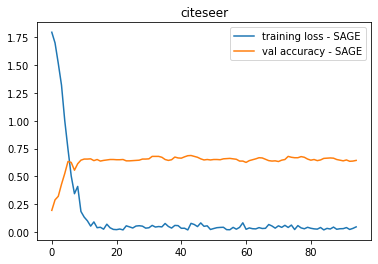

Accuracy of tuned model on Test set: 67.90%


In [17]:
# Test-set performance
print('Best tuned args:')
print(best_args, end='\n\n')
best_args['verbose'] = True
best_args = objectview(best_args)

dataset = Planetoid('/tmp/'+best_args.dataset, best_args.dataset)
loader = DataLoader(dataset, batch_size=best_args.batch_size, shuffle=True)

model, val_accs, losses = run(best_args)

acc = test(loader, model, is_validation=False)
print(f'Accuracy of tuned model on Test set: {100*acc:.2f}%')

### Hyperparameter Tuning for GAT

#### (i) Cora dataset

In [18]:
args = {
    'model_type': 'GAT', # "GCN"/"SAGE"/"GAT"
    'dataset': 'cora', # "cora/"citeseer"
    'num_layers': 2,
    'batch_size': 32,
    'hidden_dim': 32,
    'dropout': 0.5,
    'max_epochs': 1000,
    'p': 50,
    'opt': 'adam',
    'weight_decay': 5e-3,
    'lr': 0.01,
    'verbose': False
}

num_layers_choices = list(range(1,4))
hidden_dim_choices = list([32,64,128,256])
lr_choices = [0.001, 0.01]
dropout_choices = [0.25, 0.5]

update_keys = ['num_layers', 'hidden_dim', 'lr', 'dropout']
candidates = list(product(num_layers_choices, hidden_dim_choices, lr_choices, dropout_choices))

In [19]:
best_args, best_val_acc = args, -np.inf
for candidate in tqdm(candidates):
    args.update(dict(zip(update_keys, candidate)))
    model, val_accs, losses = run(objectview(args))
    max_val_acc = np.max(val_accs)
    if max_val_acc > best_val_acc:
        best_val_acc = max_val_acc
        best_args = args.copy()

100%|███████████████████████████████████████████| 48/48 [01:53<00:00,  2.36s/it]


Best tuned args:
{'model_type': 'GAT', 'dataset': 'cora', 'num_layers': 3, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'max_epochs': 1000, 'p': 50, 'opt': 'adam', 'weight_decay': 0.005, 'lr': 0.01, 'verbose': False}

Epoch  0 Loss:  1.9520165920257568 Val Acc.:  0.162
Epoch  10 Loss:  1.5084435939788818 Val Acc.:  0.336
Epoch  20 Loss:  0.7186834812164307 Val Acc.:  0.7
Epoch  30 Loss:  0.33987143635749817 Val Acc.:  0.742
Epoch  40 Loss:  0.2999351918697357 Val Acc.:  0.758
Epoch  50 Loss:  0.14659281075000763 Val Acc.:  0.742
Epoch  60 Loss:  0.2867625057697296 Val Acc.:  0.776
Epoch  70 Loss:  0.18626642227172852 Val Acc.:  0.726
Epoch  80 Loss:  0.14052066206932068 Val Acc.:  0.734
Epoch  90 Loss:  0.1041693389415741 Val Acc.:  0.748
Epoch  100 Loss:  0.17470934987068176 Val Acc.:  0.742
Epoch  110 Loss:  0.11771800369024277 Val Acc.:  0.758
Epoch  120 Loss:  0.14407627284526825 Val Acc.:  0.756
Early Stopping... Returning best weights!


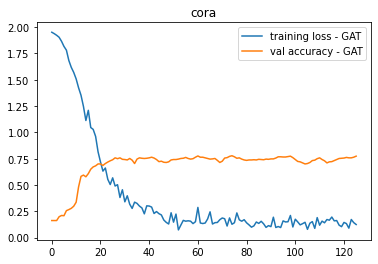

Accuracy of tuned model on Test set: 77.10%


In [20]:
# Test-set performance
print('Best tuned args:')
print(best_args, end='\n\n')
best_args['verbose'] = True
best_args = objectview(best_args)

dataset = Planetoid('/tmp/'+best_args.dataset, best_args.dataset)
loader = DataLoader(dataset, batch_size=best_args.batch_size, shuffle=True)

model, val_accs, losses = run(best_args)

acc = test(loader, model, is_validation=False)
print(f'Accuracy of tuned model on Test set: {100*acc:.2f}%')

#### (iI) Citeseer dataset

In [21]:
args = {
    'model_type': 'GAT', # "GCN"/"SAGE"/"GAT"
    'dataset': 'citeseer', # "cora"/"citeseer"
    'num_layers': 2,
    'batch_size': 32,
    'hidden_dim': 32,
    'dropout': 0.5,
    'max_epochs': 1000,
    'p': 50,
    'opt': 'adam',
    'weight_decay': 5e-3,
    'lr': 0.01,
    'verbose': False
}

num_layers_choices = list(range(1,4))
hidden_dim_choices = list([32,64,128,256])
lr_choices = [0.001, 0.01]
dropout_choices = [0.25, 0.5]

update_keys = ['num_layers', 'hidden_dim', 'lr', 'dropout']
candidates = list(product(num_layers_choices, hidden_dim_choices, lr_choices, dropout_choices))

In [22]:
best_args, best_val_acc = args, -np.inf
for candidate in tqdm(candidates):
    args.update(dict(zip(update_keys, candidate)))
    model, val_accs, losses = run(objectview(args))
    max_val_acc = np.max(val_accs)
    if max_val_acc > best_val_acc:
        best_val_acc = max_val_acc
        best_args = args.copy()

100%|███████████████████████████████████████████| 48/48 [03:30<00:00,  4.39s/it]


Best tuned args:
{'model_type': 'GAT', 'dataset': 'citeseer', 'num_layers': 2, 'batch_size': 32, 'hidden_dim': 128, 'dropout': 0.5, 'max_epochs': 1000, 'p': 50, 'opt': 'adam', 'weight_decay': 0.005, 'lr': 0.001, 'verbose': False}

Epoch  0 Loss:  1.7996041774749756 Val Acc.:  0.232
Epoch  10 Loss:  1.6580015420913696 Val Acc.:  0.496
Epoch  20 Loss:  1.3306159973144531 Val Acc.:  0.67
Epoch  30 Loss:  0.7394847273826599 Val Acc.:  0.698
Epoch  40 Loss:  0.3002704381942749 Val Acc.:  0.698
Epoch  50 Loss:  0.12080825120210648 Val Acc.:  0.688
Epoch  60 Loss:  0.05310270935297012 Val Acc.:  0.688
Epoch  70 Loss:  0.028449703007936478 Val Acc.:  0.692
Epoch  80 Loss:  0.045300137251615524 Val Acc.:  0.68
Early Stopping... Returning best weights!


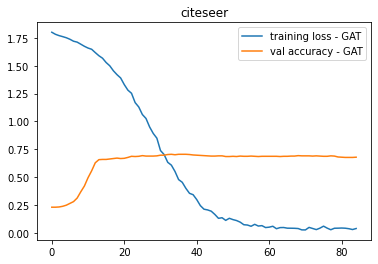

Accuracy of tuned model on Test set: 70.90%


In [23]:
# Test-set performance
print('Best tuned args:')
print(best_args, end='\n\n')
best_args['verbose'] = True
best_args = objectview(best_args)

dataset = Planetoid('/tmp/'+best_args.dataset, best_args.dataset)
loader = DataLoader(dataset, batch_size=best_args.batch_size, shuffle=True)

model, val_accs, losses = run(best_args)

acc = test(loader, model, is_validation=False)
print(f'Accuracy of tuned model on Test set: {100*acc:.2f}%')

### Effect of certain hyperparameters on test performance

In [24]:
# helper function
def get_test_accuracy(args):
    dataset = Planetoid('/tmp/'+args.dataset, args.dataset)
    loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
    model, val_accs, losses = run(args)
    return test(loader, model, is_validation=False)

### GCN
Effect of `num_layers`

100%|███████████████████████████████████████████| 10/10 [00:42<00:00,  4.23s/it]


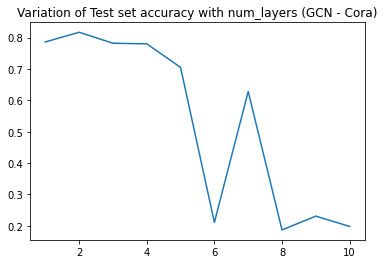

In [25]:
args = {'model_type': 'GCN', 'dataset': 'cora', 'num_layers': 2, 'batch_size': 32,
        'hidden_dim': 64, 'dropout': 0.25, 'max_epochs': 1000, 'p': 50, 'opt': 'adam',
        'weight_decay': 0.005, 'lr': 0.01, 'verbose': False}

num_layers_choices = list(range(1,11))
test_accs = {}
for num_layers in tqdm(num_layers_choices):
    args['num_layers'] = num_layers
    test_accs[num_layers] = get_test_accuracy(objectview(args))
    
plt.plot(test_accs.keys(), test_accs.values())
plt.title('Variation of Test set accuracy with num_layers (GCN - Cora)')
plt.show()

#### SAGE

Effect of `num_layers`


100%|███████████████████████████████████████████| 10/10 [00:26<00:00,  2.60s/it]


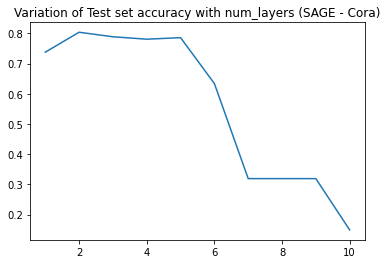

In [26]:
args = {'model_type': 'SAGE', 'dataset': 'cora', 'num_layers': 3, 'batch_size': 32,
        'hidden_dim': 32, 'dropout': 0.5, 'max_epochs': 1000, 'p': 50, 'opt': 'adam',
        'weight_decay': 0.005, 'lr': 0.01, 'verbose': False}

num_layers_choices = list(range(1,11))
test_accs = {}
for num_layers in tqdm(num_layers_choices):
    args['num_layers'] = num_layers
    test_accs[num_layers] = get_test_accuracy(objectview(args))
    
plt.plot(test_accs.keys(), test_accs.values())
plt.title('Variation of Test set accuracy with num_layers (SAGE - Cora)')
plt.show()

### GCN
Effect of `hidden_dim`

100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.85s/it]


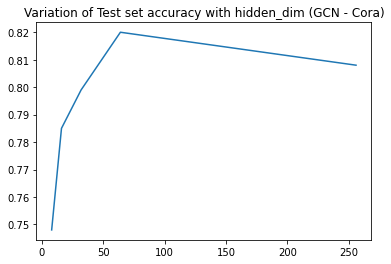

In [27]:
args = {'model_type': 'GCN', 'dataset': 'cora', 'num_layers': 2, 'batch_size': 32,
        'hidden_dim': 64, 'dropout': 0.25, 'max_epochs': 1000, 'p': 50, 'opt': 'adam',
        'weight_decay': 0.005, 'lr': 0.01, 'verbose': False}

hidden_dim_choices = [8,16,32,64,128,256]
test_accs = {}
for hidden_dim in tqdm(hidden_dim_choices):
    args['hidden_dim'] = hidden_dim
    test_accs[hidden_dim] = get_test_accuracy(objectview(args))
    
plt.plot(test_accs.keys(), test_accs.values())
plt.title('Variation of Test set accuracy with hidden_dim (GCN - Cora)')
plt.show()

#### SAGE

Effect of `hidden_dim`


100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.48s/it]


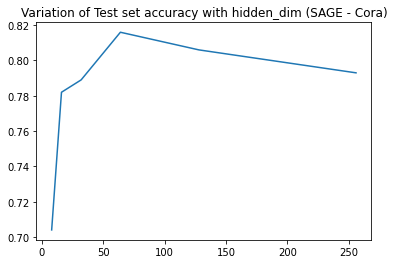

In [28]:
args = {'model_type': 'SAGE', 'dataset': 'cora', 'num_layers': 3, 'batch_size': 32,
        'hidden_dim': 32, 'dropout': 0.5, 'max_epochs': 1000, 'p': 50, 'opt': 'adam',
        'weight_decay': 0.005, 'lr': 0.01, 'verbose': False}

hidden_dim_choices = [8,16,32,64,128,256]
test_accs = {}
for hidden_dim in tqdm(hidden_dim_choices):
    args['hidden_dim'] = hidden_dim
    test_accs[hidden_dim] = get_test_accuracy(objectview(args))
    
plt.plot(test_accs.keys(), test_accs.values())
plt.title('Variation of Test set accuracy with hidden_dim (SAGE - Cora)')
plt.show()